### Import

In [1]:
# Standard Python modules
import os, sys
import yaml
import numpy as np
import pandas as pd
import xarray as xr
# matplotlib
import matplotlib.pyplot as plt

# plot styles/formatting
import seaborn as sns
import cmocean.cm as cmo
import cmocean

# statistics kit
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
import statsmodels.api as sm

In [2]:
# Set up paths

path_to_data = '/home/nash/DATA/data/'                                      # project data -- read only
path_to_out  = '../out/'       # output files (numerical results, intermediate datafiles) -- read & write
path_to_figs = '../figs/'      # figures

### AR Data

In [3]:
mode = 'max'
df = pd.read_csv(path_to_out + 'DJF_ivt_ar_types_freezing_level_max_prec_new.csv')
ylim_max = 375


In [4]:
## some maintenence for the df 
## add month and year columns
df = df.drop(columns=['Unnamed: 0'])
frame = pd.to_datetime(df.start_date.values)
frame = pd.DataFrame([frame]).transpose()
frame['date']= frame
df['month']= frame['date'].dt.month
df['year']= frame['date'].dt.year

# ## select only AR events that resulted in more than 0.1 mm of rainfall per event
# idx = (df.prec > 0.1)
# df = df.loc[idx]
# print(len(df))

## make single column for freezing level
arcat_lst = [1, 2, 3]
refcol_lst = ['western', 'northwestern', 'eastern']

df['freeze'] = 0

df.loc[df['ar_cat'] == 1, 'freeze'] = df['western_freeze']
df.loc[df['ar_cat'] == 2, 'freeze'] = df['northwestern_freeze']
df.loc[df['ar_cat'] == 3, 'freeze'] = df['eastern_freeze']

## fix ivtdir - get rid of units and convert to float
df['ivtdir_new'] = df['ivtdir'].apply(lambda x: float(x.strip(" degree")))

In [10]:
df.loc[(df.trackID == 59206.0)]

,date,trackID,ar_cat,start_date,end_date,duration,landslideID,landslide_lat,landslide_lon,prec,...,northwestern_high,eastern_low,eastern_high,western_freeze,northwestern_freeze,eastern_freeze,month,year,freeze,ivtdir_new
252,1998-02-13,59206.0,1.0,1998-02-13 00:00:00,1998-02-15 12:00:00,60.0,NaN,NaN,NaN,129.489746,...,479.347345,-136.948306,276.086847,1,1,-1,2,1998,1,184.785728
253,1998-02-12,59206.0,2.0,1998-02-12 06:00:00,1998-02-13 00:00:00,18.0,NaN,NaN,NaN,36.930542,...,690.233127,-158.778189,161.203917,1,1,-1,2,1998,1,235.992695


In [5]:
artype_lst = [1, 2, 3]
rsquared = []
case_study = []
for i, ar_type in enumerate(artype_lst):
    
    # select ar category
    idx = (df.ar_cat == ar_type) 
    data1 = df.loc[idx]
    print('AR Type:', refcol_lst[i])
    ## Calculate Linear regression
    # X = data1['ivt'] # single variable
    # X = data1['duration'] # single variable
    # X = data1['ivtdir_new'] # single variable
    X = np.column_stack((data1['ivt'], data1['duration'])) # multiple linear regression
    y = data1['prec']

    X2 = sm.add_constant(X)
    est = sm.OLS(y, X2, missing='drop')
    est2 = est.fit()
    print(est2.summary())
    rsquared.append(est2.rsquared)
    
    ## get 85th percentile of ivt and precip
    ivt_thres = data1['ivt'].describe(percentiles=[.85]).loc['85%']
    prec_thres = data1['prec'].describe(percentiles=[.85]).loc['85%']
    
    # select only events above 85th percentile
    idx = (data1['prec'] >= prec_thres) & (data1['ivt'] >= ivt_thres)
    data_new = data1.loc[idx]
    case_study.append(data_new)
    
    print('Number of cases about 85th percentile', len(data_new))

AR Type: western
                            OLS Regression Results                            
Dep. Variable:                   prec   R-squared:                       0.769
Model:                            OLS   Adj. R-squared:                  0.767
Method:                 Least Squares   F-statistic:                     464.7
Date:                Tue, 13 Dec 2022   Prob (F-statistic):           1.57e-89
Time:                        17:33:45   Log-Likelihood:                -1280.6
No. Observations:                 282   AIC:                             2567.
Df Residuals:                     279   BIC:                             2578.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        -36.0654      3.078   

In [6]:
## case study selection 
## events that are western AR type, above average freezing level, and precipitation exceeds 85th percentile
case_study[0].loc[(case_study[0].freeze == 1)]

,date,trackID,ar_cat,start_date,end_date,duration,landslideID,landslide_lat,landslide_lon,prec,...,northwestern_high,eastern_low,eastern_high,western_freeze,northwestern_freeze,eastern_freeze,month,year,freeze,ivtdir_new
124,1990-01-16,34284.0,1.0,1990-01-16 00:00:00,1990-01-20 00:00:00,96.0,NaN,NaN,NaN,81.498291,...,NaN,-97.625463,501.350976,1,-1,1,1,1990,1,242.885975
149,1991-01-26,37457.0,1.0,1991-01-26 00:00:00,1991-01-28 12:00:00,60.0,NaN,NaN,NaN,174.387573,...,647.148168,-142.500831,373.315413,1,1,1,1,1991,1,246.744334
202,1995-02-10,49910.0,1.0,1995-02-10 06:00:00,1995-02-12 00:00:00,42.0,NaN,NaN,NaN,100.473633,...,441.469299,-399.131090,NaN,1,1,-1,2,1995,1,219.010415
252,1998-02-13,59206.0,1.0,1998-02-13 00:00:00,1998-02-15 12:00:00,60.0,NaN,NaN,NaN,129.489746,...,479.347345,-136.948306,276.086847,1,1,-1,2,1998,1,184.785728
265,1999-02-22,62359.0,1.0,1999-02-22 00:00:00,1999-02-22 18:00:00,18.0,NaN,NaN,NaN,52.131104,...,441.652335,-102.506013,445.491192,1,-1,1,2,1999,1,245.944068
270,2000-12-15,68106.0,1.0,2000-12-15 12:00:00,2000-12-17 00:00:00,36.0,NaN,NaN,NaN,50.933228,...,617.396610,-170.226304,470.509912,1,1,1,12,2000,1,225.058090
353,2006-02-23,84815.0,1.0,2006-02-23 12:00:00,2006-02-26 00:00:00,60.0,NaN,NaN,NaN,121.703613,...,NaN,-111.149443,690.213439,1,-1,1,2,2006,1,238.695802
387,2008-12-19,94008.0,1.0,2008-12-19 06:00:00,2008-12-20 00:00:00,18.0,940.0,33.245,75.247,80.424438,...,NaN,NaN,1137.752255,1,-1,1,12,2008,1,205.953216
417,2011-02-03,101040.0,1.0,2011-02-03 00:00:00,2011-02-04 00:00:00,24.0,NaN,NaN,NaN,72.551758,...,670.848730,-154.430634,498.192686,1,1,1,2,2011,1,236.840583


In [7]:
## events that are western AR type, below average freezing level, and precipitation exceeds 85th percentile
case_study[0].loc[(case_study[0].freeze == -1)]

,date,trackID,ar_cat,start_date,end_date,duration,landslideID,landslide_lat,landslide_lon,prec,...,northwestern_high,eastern_low,eastern_high,western_freeze,northwestern_freeze,eastern_freeze,month,year,freeze,ivtdir_new
52,1982-12-07,12271.0,1.0,1982-12-07 06:00:00,1982-12-09 12:00:00,54.0,NaN,NaN,NaN,88.043701,...,NaN,-463.097307,NaN,-1,-1,-1,12,1982,-1,236.547437
58,1983-01-26,12649.0,1.0,1983-01-26 12:00:00,1983-01-28 12:00:00,48.0,NaN,NaN,NaN,106.729004,...,NaN,-702.266026,NaN,-1,-1,-1,1,1983,-1,163.825733
109,1989-01-04,31016.0,1.0,1989-01-04 00:00:00,1989-01-06 12:00:00,60.0,NaN,NaN,NaN,176.232910,...,NaN,-881.629965,NaN,-1,-1,-1,1,1989,-1,167.719870
145,1990-12-26,37230.0,1.0,1990-12-26 00:00:00,1990-12-29 00:00:00,72.0,NaN,NaN,NaN,274.049561,...,413.669319,-108.499574,223.144075,-1,1,-1,12,1990,-1,185.563659
159,1992-01-22,40590.0,1.0,1992-01-22 00:00:00,1992-01-30 00:00:00,192.0,NaN,NaN,NaN,363.083252,...,431.815615,-797.498877,NaN,-1,1,-1,1,1992,-1,181.843168
184,1993-02-24,43950.0,1.0,1993-02-24 12:00:00,1993-02-26 00:00:00,36.0,NaN,NaN,NaN,108.970215,...,NaN,-556.954842,NaN,-1,-1,-1,2,1993,-1,165.196719
224,1996-02-22,53118.0,1.0,1996-02-22 00:00:00,1996-02-24 00:00:00,48.0,NaN,NaN,NaN,77.231934,...,NaN,-540.710974,NaN,-1,-1,-1,2,1996,-1,189.329422
230,1997-01-18,55893.0,1.0,1997-01-18 00:00:00,1997-01-19 00:00:00,24.0,NaN,NaN,NaN,56.174805,...,NaN,-777.071044,NaN,-1,-1,-1,1,1997,-1,157.402663
295,2003-02-16,74983.0,1.0,2003-02-16 00:00:00,2003-02-17 00:00:00,24.0,NaN,NaN,NaN,70.100098,...,NaN,-193.740924,NaN,-1,-1,-1,2,2003,-1,169.892885
296,2003-02-17,74922.0,1.0,2003-02-17 00:00:00,2003-02-18 00:00:00,24.0,NaN,NaN,NaN,160.501343,...,NaN,-151.768071,NaN,-1,-1,-1,2,2003,-1,182.271717


## Plot IVT/Precip Scatter and IVT direction and precipitation in windrose

Use https://gist.github.com/phobson/41b41bdd157a2bcf6e14 as an example

In [8]:
## Define a function that gives nice labels for precipitation ranges

def range_labels(bins, units):   
    labels = []
    for left, right in zip(bins[:-1], bins[1:]):
        if left == bins[0]:
            labels.append('clear'.format(right))
        elif np.isinf(right):
            labels.append('>{} {}'.format(left, units))
        else:
            labels.append('{} - {} {}'.format(left, right, units))

    return list(labels)

## Define a function to convert centered angles to left-edge radians
def _convert_dir(directions, N=None):
    if N is None:
        N = directions.shape[0]
    barDir = directions * np.pi/180. - np.pi/N
    barWidth = 2 * np.pi / N
    return barDir, barWidth

## define wind rose function
def wind_rose(ax, rosedata, wind_dirs, legend_req, palette=None):
    if palette is None:
        palette = sns.color_palette('inferno', n_colors=rosedata.shape[1])
    else:
        palette = sns.color_palette(palette, n_colors=rosedata.shape[1])

    bar_dir, bar_width = _convert_dir(wind_dirs)

    
    ax.set_theta_direction('clockwise')
    ax.set_theta_zero_location('N')

    for n, (c1, c2) in enumerate(zip(rosedata.columns[:-1], rosedata.columns[1:])):
        if n == 0:
            # first column only
            ax.bar(bar_dir, rosedata[c1].values, 
                   width=bar_width,
                   color=palette[0],
                   edgecolor='none',
                   label=c1,
                   linewidth=0)

        # all other columns
        ax.bar(bar_dir, rosedata[c2].values, 
               width=bar_width, 
               bottom=rosedata.cumsum(axis=1)[c1].values,
               color=palette[n+1],
               edgecolor='none',
               label=c2,
               linewidth=0)

    xtl = ax.set_xticklabels(['N', 'NE', 'E', 'SE', 'S', 'SW', 'W', 'NW'])
    
    if legend_req == True:
        leg = ax.legend(loc=(0.75, 0.95), ncol=1)
    
    return ax

def calc_rose(df, prec_bins, prec_labels, dir_bins, dir_labels):
    '''
    ### Determine the relative percentage of observation in each speed and direction bin
    Here's how we do it:

    - assign a precipitation bin for each row with pandas.cut
    - assign a direction bin for each row (again, pandas.cut)
    - unify the 360° and 0° bins under the 0° label
    - group the data simultaneously on both precipitation and direction bins
    - compute the size of each group
    - unstack (pivot) the speed bins into columns
    - fill missing values with 0
    - assign a "calm" column to be the total number of calm observations evenly distributed across all directions
    - sort the columns -- they are a catgerical index, so "calm" will be first (this is awesome!)
    - convert all of the counts to percentages of the total number of observations
    '''
    total_count = df.shape[0]
    calm_count = df.query("prec < 2").shape[0]
    print('Of {} total observations, {} have less than 2 mm of precipitation.'.format(total_count, calm_count))
    
    df = (df.assign(prec_bins=lambda df: pd.cut(df['prec'], bins=prec_bins, labels=prec_labels, right=True))
          .assign(ivtdir_bins=lambda df: pd.cut(df['ivtdir_new'], bins=dir_bins, labels=dir_labels, right=False))
          .replace({'ivtdir_bins': {360: 0}})
          .groupby(by=['prec_bins', 'ivtdir_bins'])
          .size()
          .unstack(level='prec_bins')
          .fillna(0)
          .assign(clear=lambda df: calm_count / df.shape[0])
          .sort_index(axis=1)
          .applymap(lambda x: x / total_count * 100))
        
    return df

Of 314 total observations, 14 have less than 2 mm of precipitation.


/home/sbarc/students/nash/miniconda3/envs/ar_types/lib/python3.7/site-packages/ipykernel_launcher.py:55: UserWarning: FixedFormatter should only be used together with FixedLocator


Of 302 total observations, 20 have less than 2 mm of precipitation.


/home/sbarc/students/nash/miniconda3/envs/ar_types/lib/python3.7/site-packages/ipykernel_launcher.py:55: UserWarning: FixedFormatter should only be used together with FixedLocator


Of 372 total observations, 18 have less than 2 mm of precipitation.


/home/sbarc/students/nash/miniconda3/envs/ar_types/lib/python3.7/site-packages/ipykernel_launcher.py:55: UserWarning: FixedFormatter should only be used together with FixedLocator


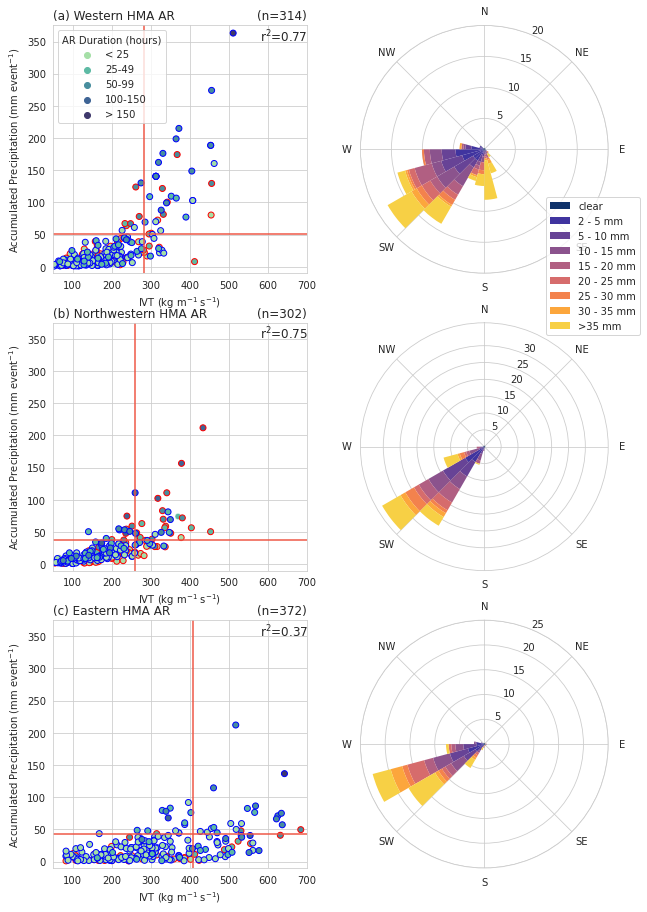

../figs/wrf_scatter_rosemax.png


In [9]:
## update plot so that it is 3 columns (ar type) by 1 rows (location of precip)
fname = path_to_figs + 'wrf_scatter_rose' + mode
fmt = 'png'
nrows = 3
ncols = 2
nplots=nrows*ncols

fig = plt.figure(figsize=(10,15.5))

region_lst = ['western'] + ['northwestern'] + ['eastern']
artype_lst = [1, 2, 3]
plt_lbl = ['(a) Western HMA AR', '(b) Northwestern HMA AR', '(c) Eastern HMA AR']

colors = np.array(([239/256, 86/256, 69/256, 1], # UCSB coral
                   [254/256, 188/256, 17/256, 1], # UCSB gold
                   [4/256, 124/256, 145/256], # UCSB aqua
                   [156/256, 190/256, 190/256], # UCSB mist
                  ), dtype='object')

jan2002ID = 71513
feb2011ID = 101129
feb2010ID = 97756
id1 = jan2002ID
id2 = feb2010ID
case_study = [(id1, id2), (id1, id2), (id1, id2)]


sns.set_style("whitegrid")
legend_lst = [True, False, False]
subplt_no = [1, 3, 5]
for i, ar_type in enumerate(artype_lst):
    ax = fig.add_subplot(nrows, ncols, subplt_no[i])
    
    # plot ALL cases
    idx = (df.ar_cat == ar_type) 
    data1 = df.loc[idx]
    n = len(data1)
    
    # sort data by duration
    test=data1.sort_values('duration')
    test['AR Duration (hours)'] = pd.cut(test["duration"], [0, 25, 50, 100, 150, 300], labels=["< 25", "25-49", "50-99", "100-150", "> 150"])
    cpal = sns.color_palette("cmo.deep", n_colors=5)
    g = sns.scatterplot(data=test, x="ivt", y="prec", ax=ax, hue='AR Duration (hours)',  palette=cpal, legend=legend_lst[i])
    
    ## get 85th percentile of ivt and precip
    ivt_thres = data1['ivt'].describe(percentiles=[.85]).loc['85%']
    prec_thres = data1['prec'].describe(percentiles=[.85]).loc['85%']
    
    plt.axhline(y=prec_thres, color=colors[0], linestyle='-')
    plt.axvline(x=ivt_thres, color=colors[0], linestyle='-')
    
    ## plot case study points
    idx = (test.trackID == case_study[i][0]) | (test.trackID == case_study[i][1])
    data3 = test.loc[idx]
    kwargs = {'edgecolor': colors[1], 'linewidth': 1.5}
    gb = sns.scatterplot(data=data3, x="ivt", y="prec", ax=ax, marker='o', hue='AR Duration (hours)',  palette=cpal, **kwargs, legend=False)
    
#     ## plot freezing level
#     warm = test.loc[(test.freeze == 1)]
#     kwargs = {'edgecolor': 'red', 'linewidth': 1.}
#     gb = sns.scatterplot(data=warm, x="ivt", y="prec", ax=ax, marker='o', hue='AR Duration (hours)',  palette=cpal, **kwargs, legend=False)
    
#     cold = test.loc[(test.freeze == -1)]
#     kwargs = {'edgecolor': 'blue', 'linewidth': 1.}
#     gb2 = sns.scatterplot(data=cold, x="ivt", y="prec", ax=ax, marker='o', hue='AR Duration (hours)',  palette=cpal, **kwargs, legend=False)
    
    # # plot landslide cases
    # landslide = test.loc[(test.landslideID > 0)]
    # print('No. of landslides:', landslide.landslideID.unique())
    # kwargs = {'edgecolor': 'red', 'linewidth': 1.}
    # gb = sns.scatterplot(data=landslide, x="ivt", y="prec", ax=ax, marker='o', hue='AR Duration (hours)',  palette=cpal, **kwargs, legend=False)
    
    
    ax.set_ylabel('Accumulated Precipitation (mm event$^{-1}$)')
    ax.set_xlabel('IVT (kg m$^{-1}$ s$^{-1}$)')
    ax.set_ylim(-10, 375)
    ax.set_xlim(50, 700)
    ax.set_title(plt_lbl[i], loc='left')
    ax.set_title('(n={0})'.format(n), loc='right')
    # rval = u"r$^{2}$ {:.2f}".format(rsquared[i])
    rval = u"r$^{2}$=" + "{:.2f}".format(rsquared[i])
    ax.text(580, 350, rval, fontsize=12)
    
#####################
### PLOT WINDROSE ###
#####################
original_df = df # save a copy of the original

## Define our bins and labels for speed and wind
prec_bins = [0, 2, 5, 10, 15, 20, 25, 30, 35, np.inf]
prec_labels = range_labels(prec_bins, units='mm')

dir_bins = np.arange(-7.5, 370, 15)
dir_labels = (dir_bins[:-1] + dir_bins[1:]) / 2

## use wind rose function
directions = np.arange(0, 360, 15)

legend_req = [False, True, False]
plt_lbl = ['(d)', '(e)', '(f)']
subplt_no = [2, 4, 6]
rad_ticks = [[5, 10, 15, 20], [5, 10, 15, 20, 25, 30], [5, 10, 15, 20, 25]]
## loop through each AR type to plot wind rose
for i, ar in enumerate(artype_lst):
    ax = fig.add_subplot(nrows, ncols, subplt_no[i], projection='polar')
    tmp = original_df.loc[(original_df.ar_cat == ar)]
    rose = calc_rose(tmp, prec_bins, prec_labels, dir_bins, dir_labels)
    
    ax = wind_rose(ax, rose, directions, legend_req[i], palette="cmo.thermal")

    ax.set_rticks(rad_ticks[i])  # Less radial ticks

# Save the figure
fig.savefig('%s.%s' % (fname, fmt), bbox_inches='tight', dpi=300)
plt.show()
fig.clf()

plotFile = fname + '.png'
print(plotFile)
